In [1]:
import pickle
import os
import fnmatch
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.transforms as mtransforms
import time
from mpl_toolkits import mplot3d
import seaborn as sns
from math import ceil
import re

In [2]:
def BER(N,p,eng_list):
    ber = 0
    p = np.array(p)
    
    for k in range(len(p)):
        if k+1< len(p):
            ber += (np.sum(p[k:])**N - np.sum(p[k+1:])**N)*eng_list[k]
        else:
            ber += p[k]**N * eng_list[k]
    return np.round(ber,8)

def cumulative(energy, p, eng_list):
    # energy is the energy threshold
    cumulative_dist = np.cumsum(p)
    if min(eng_list) > energy:
        return 0
    elif max(eng_list) < energy:
        return 1
    
    for i, E in enumerate(eng_list):
        
        if E > energy:
            return cumulative_dist[i-1]

    return 1

def confidence_prob(N, p, eng_list, eng_th):
    F = cumulative(eng_th , p, eng_list)
    
    return 1-(1-F)**N

def invCDF(N, prob, eng_list, conf = 0.99):
    cdf = np.cumsum(prob)    
    threshold = 1 - (1-conf)**(1/N)
    for idx, p in enumerate(cdf):
        
        if p >= threshold:
            if idx ==0:
                return eng_list[0]
            else:
                return eng_list[idx]
            
def failure_prob(N, p, eng_list, eng_th):
    F = cumulative(eng_th , p, eng_list)
    
    return (1-F)**N

def runs(Eth, conf, prob, eng_list ):
    F = cumulative(Eth, prob, eng_list)
    if F == 1:
        return 1
    else:
        return np.log(1-conf)/np.log(1-F)


In [3]:
def plot_avg_cumulatives(NQ, N_runs = 1000, method = "avg"):
    path = "normalized_prob_dist/QPSK/"+ method + "/N=" + str(N_runs) + "/"
    
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    avg_cumulative = np.zeros(1001)
    
    for problem in range(1, 21):
        df_cum = pd.read_csv(path + "cumulative_norm_NQ=" + str(NQ) + "_problem=" + str(problem) + "_N=" + str(N_runs) + ".csv", index_col = 0)
        ax.plot(df_cum["eng"], df_cum["cumulative"], c = "grey", alpha = 0.5 )
        avg_cumulative += df_cum["cumulative"].values/20
    
    ax.plot(df_cum["eng"], avg_cumulative, c = "r", label = "Mean")
    
    for idx, conf in enumerate(avg_cumulative):
        if conf >= 0.9:
            E_pass_test = df_cum["eng"][idx]
            break
    
    ax.axhline(0.90, xmin = 0, xmax = 1, c = "navy", ls=":", linewidth=2.5,zorder=0)
    ax.axvline(E_pass_test, c = "navy", ls=":", linewidth=2.5,zorder=0 )
    
    ax.set_xlabel('E', fontsize = 25)
    ax.set_ylabel("Probability",  fontsize = 25)
    fig.legend(loc=(0.9,0.1))
    plt.show()
    
    path_plots = "new_plots/" + method + "/mean/"
    if not os.path.exists(path_plots):
        os.makedirs(path_plots)
    
    title = "cumaltives_NQ=" + str(NQ) + "mean_N=" + str(N_runs) + ".pdf"
    
    fig.savefig(path_plots + title +  ".pdf", bbox_inches='tight') 
    plt.close(fig)

    

In [4]:
def plot_avg_pass(method = "avg"):
    df_total_file = "normalized_prob_dist/QPSK/" + method + "/all_avg/avg_pass_test.csv"
    N_runs_list = list(range(1,1001))
    
    df_total = pd.read_csv(df_total_file, index_col = 0)
    
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    for problem in range(1,21):
        ax.plot(N_runs_list[:1001], df_total[str(problem)].values[:1000], c = "grey", alpha = 0.5 )
    ax.plot(N_runs_list, df_total["avg"], c = "r", label = "Mean" )
    
    ax.set_xlabel('#N', fontsize = 25)
    ax.set_ylabel("E",  fontsize = 25)
    fig.legend(loc=(0.9,0.9))
    plt.show()
    
    path_plots = "new_plots/" + method + "/runs_pass_test/"
    if not os.path.exists(path_plots):
        os.makedirs(path_plots)
    
    title = "pass_test_NQ=" + str(44) + "_total_1.pdf"
    
    fig.savefig(path_plots + title +  ".pdf", bbox_inches='tight') 
    plt.close(fig)


In [7]:
def plot_hardness_full(N_runs = 2000, style = "lin"):

    df_total_file_avg = "normalized_prob_dist/QPSK/avg/all_avg/avg_pass_test_N="+str(N_runs)+".csv"
    df_total_file_opt = "normalized_prob_dist/QPSK/opt/all_avg/avg_pass_test_N="+str(N_runs)+".csv"
    N_runs_list = np.array(range(1,N_runs + 1)) * 0.127 + 37
    
    df_total_avg = pd.read_csv(df_total_file_avg, index_col = 0)
    df_total_opt = pd.read_csv(df_total_file_opt, index_col = 0)
    
    
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,5),(0,0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((2,5),(0,2),  rowspan=2)#, sharey=ax1)
    ax3 = plt.subplot2grid((2,5),(0,3),  rowspan=2)#, sharey=ax2)
    ax4 = plt.subplot2grid((2,5),(0,4),  rowspan=2)#, sharey=ax2)
#     ax5 = plt.subplot2grid((2,6),(0,5),  rowspan=2, sharey=ax1)
    
    fig.subplots_adjust(wspace = 0 ) 
#     print("generation of grid plots - OK")
    fig.set_figheight(16)
    fig.set_figwidth(24)
    f_size = 40
    thickness = 5
    

    
    ax1.tick_params(axis='y',labelsize = f_size)
    ax1.tick_params(axis='x',labelsize = f_size)
    
    ax2.tick_params(axis='y',labelsize = f_size)
    ax2.tick_params(axis='x',labelsize = f_size)
    
    ax3.tick_params(axis='y',labelsize = f_size)
    ax3.tick_params(axis='x',labelsize = f_size)
    
    ax4.tick_params(axis='y',labelsize = f_size)
    ax4.tick_params(axis='x',labelsize = f_size)
#     ax1.set_ylabel("E", color="black", fontsize = f_size)  
#     print(len(df_total_avg["avg"]), len(N_runs_list))
#     print(len(df_total_opt["avg"]))
    label_avg = "Fixed"
    label_opt = "Optimal w/o OH"
    label_oh = "Optimal w/ OH"

    if style == "log":
        ax1.plot(np.log10(N_runs_list), df_total_avg["avg"], c = "r", label = label_avg, linewidth=thickness )
        ax1.plot(np.log10(N_runs_list), df_total_opt["avg"],"--", c = "xkcd:hot pink", label = label_opt, linewidth=thickness, markevery=400, markersize=12 )
        ax1.plot(np.log10(N_runs_list[:-1000] + 200), df_total_opt["avg"].values[:-1000], c = "xkcd:hot pink", label = label_oh, linewidth=thickness )
        xlim = ax1.get_ylim()
        new_xlim = (np.log10(37), np.log10(2000))
        ax1.set_xlim(new_xlim)
        ax1xticks = [1.5,2,3]
        ticks_dict = {1.5:""  ,2 : r"$10^2$", 3: r"$10^3$"}
        ax1.set_xticks(ax1xticks)
        labels = [ax1xticks[i] if t not in ticks_dict.keys() else ticks_dict[t] for i,t in enumerate(ax1xticks)]
        ax1.set_xticklabels(labels)
        ax1.arrow( np.log10(200* 0.127 + 37),df_total_opt["avg"].values[200] ,np.log10(200* 0.127 + 37+200)-np.log10(200* 0.127 + 37),0,  head_width=0.01, head_length=0.05, linewidth=4, color="black", length_includes_head=True)
        ax1.arrow(np.log10(200* 0.127 + 37+200) ,df_total_opt["avg"].values[200] ,-(np.log10(200* 0.127 + 37+200)-np.log10(200* 0.127 + 37)),0,  head_width=0.01, head_length=0.05, linewidth=4, color="black", length_includes_head=True,
                 zorder=10)
        ax1.annotate("Overhead", xy=(np.log10(280* 0.127 + 37), df_total_opt["avg"].values[200] + 0.005 ), fontsize=f_size-10)
        
    elif style == "lin":
        ax1.plot(N_runs_list, df_total_avg["avg"], c = "r", label = label_avg, linewidth=thickness )
        ax1.plot(N_runs_list, df_total_opt["avg"], c = "xkcd:magenta", label = label_opt, linewidth=thickness )
        ax1.plot(N_runs_list[:-1000] + 100, df_total_opt["avg"].values[:-1000], c = "xkcd:purple", label = label_oh, linewidth=thickness )
        
        xlim = ax1.get_ylim()
        new_xlim = (25, 1350)
        ax1.set_xlim(new_xlim)
        
    
    ylim = ax1.get_ylim()
    new_ylim = (-0.01, 0.32)
    ax1.set_ylim(new_ylim)
    
#     xlim = ax1.get_ylim()
#     new_xlim = (1, 4)
#     ax1.set_xlim(new_xlim)

    
    ax1.set_xlabel(r'$t\ [ms]$', fontsize = f_size)
    ax1.set_ylabel("E",  fontsize = f_size)
#     fig.legend(loc=(0.9,0.8))
#     plt.show()
    
    path_plots = "new_plots/hardness/"
    if not os.path.exists(path_plots):
        os.makedirs(path_plots)
    
    title = "hardnes_NQ=" + str(44) + ".pdf"
    
#     fig.savefig(path_plots + title +  ".pdf", bbox_inches='tight') 
#     plt.close(fig)
    
    
    
    path10 = "normalized_prob_dist/QPSK/avg/N=" + str(10) + "/"
    path100 = "normalized_prob_dist/QPSK/avg/N=" + str(100) + "/"
    path1000 = "normalized_prob_dist/QPSK/avg/N=" + str(1000) + "/"
    
    

    
    avg_cumulative10 = np.zeros(1001)
    avg_cumulative100 = np.zeros(1001)
    avg_cumulative1000 = np.zeros(1001)
    opacity = 0.3
    for problem in range(1, 21):
        df_cum10 = pd.read_csv(path10 + "cumulative_norm_NQ=" + str(44) + "_problem=" + str(problem) + "_N=" + str(10) + ".csv", index_col = 0)
        ax2.plot(df_cum10["eng"], df_cum10["cumulative"], c = "grey", alpha = opacity, linewidth=thickness-2 )
        avg_cumulative10 += df_cum10["cumulative"].values/20
        
        df_cum100 = pd.read_csv(path100 + "cumulative_norm_NQ=" + str(44) + "_problem=" + str(problem) + "_N=" + str(100) + ".csv", index_col = 0)
        ax3.plot(df_cum100["eng"], df_cum100["cumulative"], c = "grey", alpha = opacity, linewidth=thickness-2 )
        avg_cumulative100 += df_cum100["cumulative"].values/20
    
        df_cum1000 = pd.read_csv(path1000 + "cumulative_norm_NQ=" + str(44) + "_problem=" + str(problem) + "_N=" + str(1000) + ".csv", index_col = 0)
        ax4.plot(df_cum1000["eng"], df_cum1000["cumulative"], c = "grey", alpha = opacity, linewidth=thickness-2 )
        avg_cumulative1000 += df_cum1000["cumulative"].values/20
    
    
    ax2.plot(df_cum10["eng"], avg_cumulative10,  c = "orange", linewidth=thickness)#, markersize = 12, label = "Mean")
    ax3.plot(df_cum100["eng"], avg_cumulative100,  c = "b", linewidth=thickness)#, label = "Mean")
    ax4.plot(df_cum1000["eng"], avg_cumulative1000, c = "g", linewidth=thickness)#, label = "Mean")
    ax2.set_title("#N=10", fontsize=f_size)
    ax3.set_title("#N=100", fontsize=f_size)
    ax4.set_title("#N=1000", fontsize=f_size)
    

    for idx, conf in enumerate(avg_cumulative10):
        if conf >= 0.9:
            E_pass_test10 = df_cum10["eng"][idx]
            break
            
    for idx, conf in enumerate(avg_cumulative100):
        if conf >= 0.9:
            E_pass_test100 = df_cum100["eng"][idx]
            break
            
    for idx, conf in enumerate(avg_cumulative1000):
        if conf >= 0.9:
            E_pass_test1000 = df_cum1000["eng"][idx]
            break
    
    ax2.axhline(0.90, xmin = 0, xmax = 1, c = "navy", ls=":", linewidth=3.5,zorder=0)
    ax2.axvline(E_pass_test10, c = "navy", ls=":", linewidth=3.5,zorder=0 )
    
    ax3.axhline(0.90, xmin = 0, xmax = 1, c = "navy", ls=":", linewidth=3.5,zorder=0)
    ax3.axvline(E_pass_test100, c = "navy", ls=":", linewidth=3.5,zorder=0 )
    
    ax4.axhline(0.90, xmin = 0, xmax = 1, c = "navy", ls=":", linewidth=3.5,zorder=0)
    ax4.axvline(E_pass_test1000, c = "navy", ls=":", linewidth=3.5,zorder=0 )
    
    
    ylim = ax2.get_ylim()
    new_ylim = (-0.01, 1.01)
    ax2.set_ylim(new_ylim)
    
    labels = [item.get_text() for item in ax2.get_yticklabels()]

    empty_string_labels = ['']*len(labels)
    ax2.set_yticklabels(empty_string_labels)
    
    ylim = ax3.get_ylim()
    ax3.set_ylim(new_ylim)
    
    ylim = ax2.get_ylim()
    ax4.set_ylim(new_ylim)
    
#         ylim = ax2.get_ylim()
#     new_ylim = (-0.01, 1.0)
#     ax2.set_ylim(new_ylim)
    
    xlim = ax2.get_xlim()
    new_xlim = (-0.01, 0.35)
    ax2.set_xlim(new_xlim)
    
    xlim = ax3.get_xlim()
    ax3.set_xlim(new_xlim)
    ax3.set_yticklabels(empty_string_labels)
    
    xlim = ax4.get_xlim()
    ax4.set_xlim(new_xlim)
    
    ax4.yaxis.tick_right()
    
    ax3.set_xlabel('E', fontsize = f_size)
    ax4.set_ylabel("Probability",  fontsize = f_size)
    ax4.yaxis.set_label_position("right")
#     ax.set_xlabel('E', fontsize = 25)
#     ax.set_ylabel("Probability",  fontsize = 25)
    fig.legend(loc=(0.17,0.77), prop = {"size" : f_size-5}, framealpha=1. )
    
    plt.show()
    path_plots = "new_plots/hardness_total/"
    if not os.path.exists(path_plots):
        os.makedirs(path_plots)
    
    title = "hardness_total_" + style 
    
    fig.savefig(path_plots + title +  ".pdf", bbox_inches='tight') 
    plt.close(fig)

    

<ipython-input-7-dd4ab6232c82>:162: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(empty_string_labels)
<ipython-input-7-dd4ab6232c82>:180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(empty_string_labels)


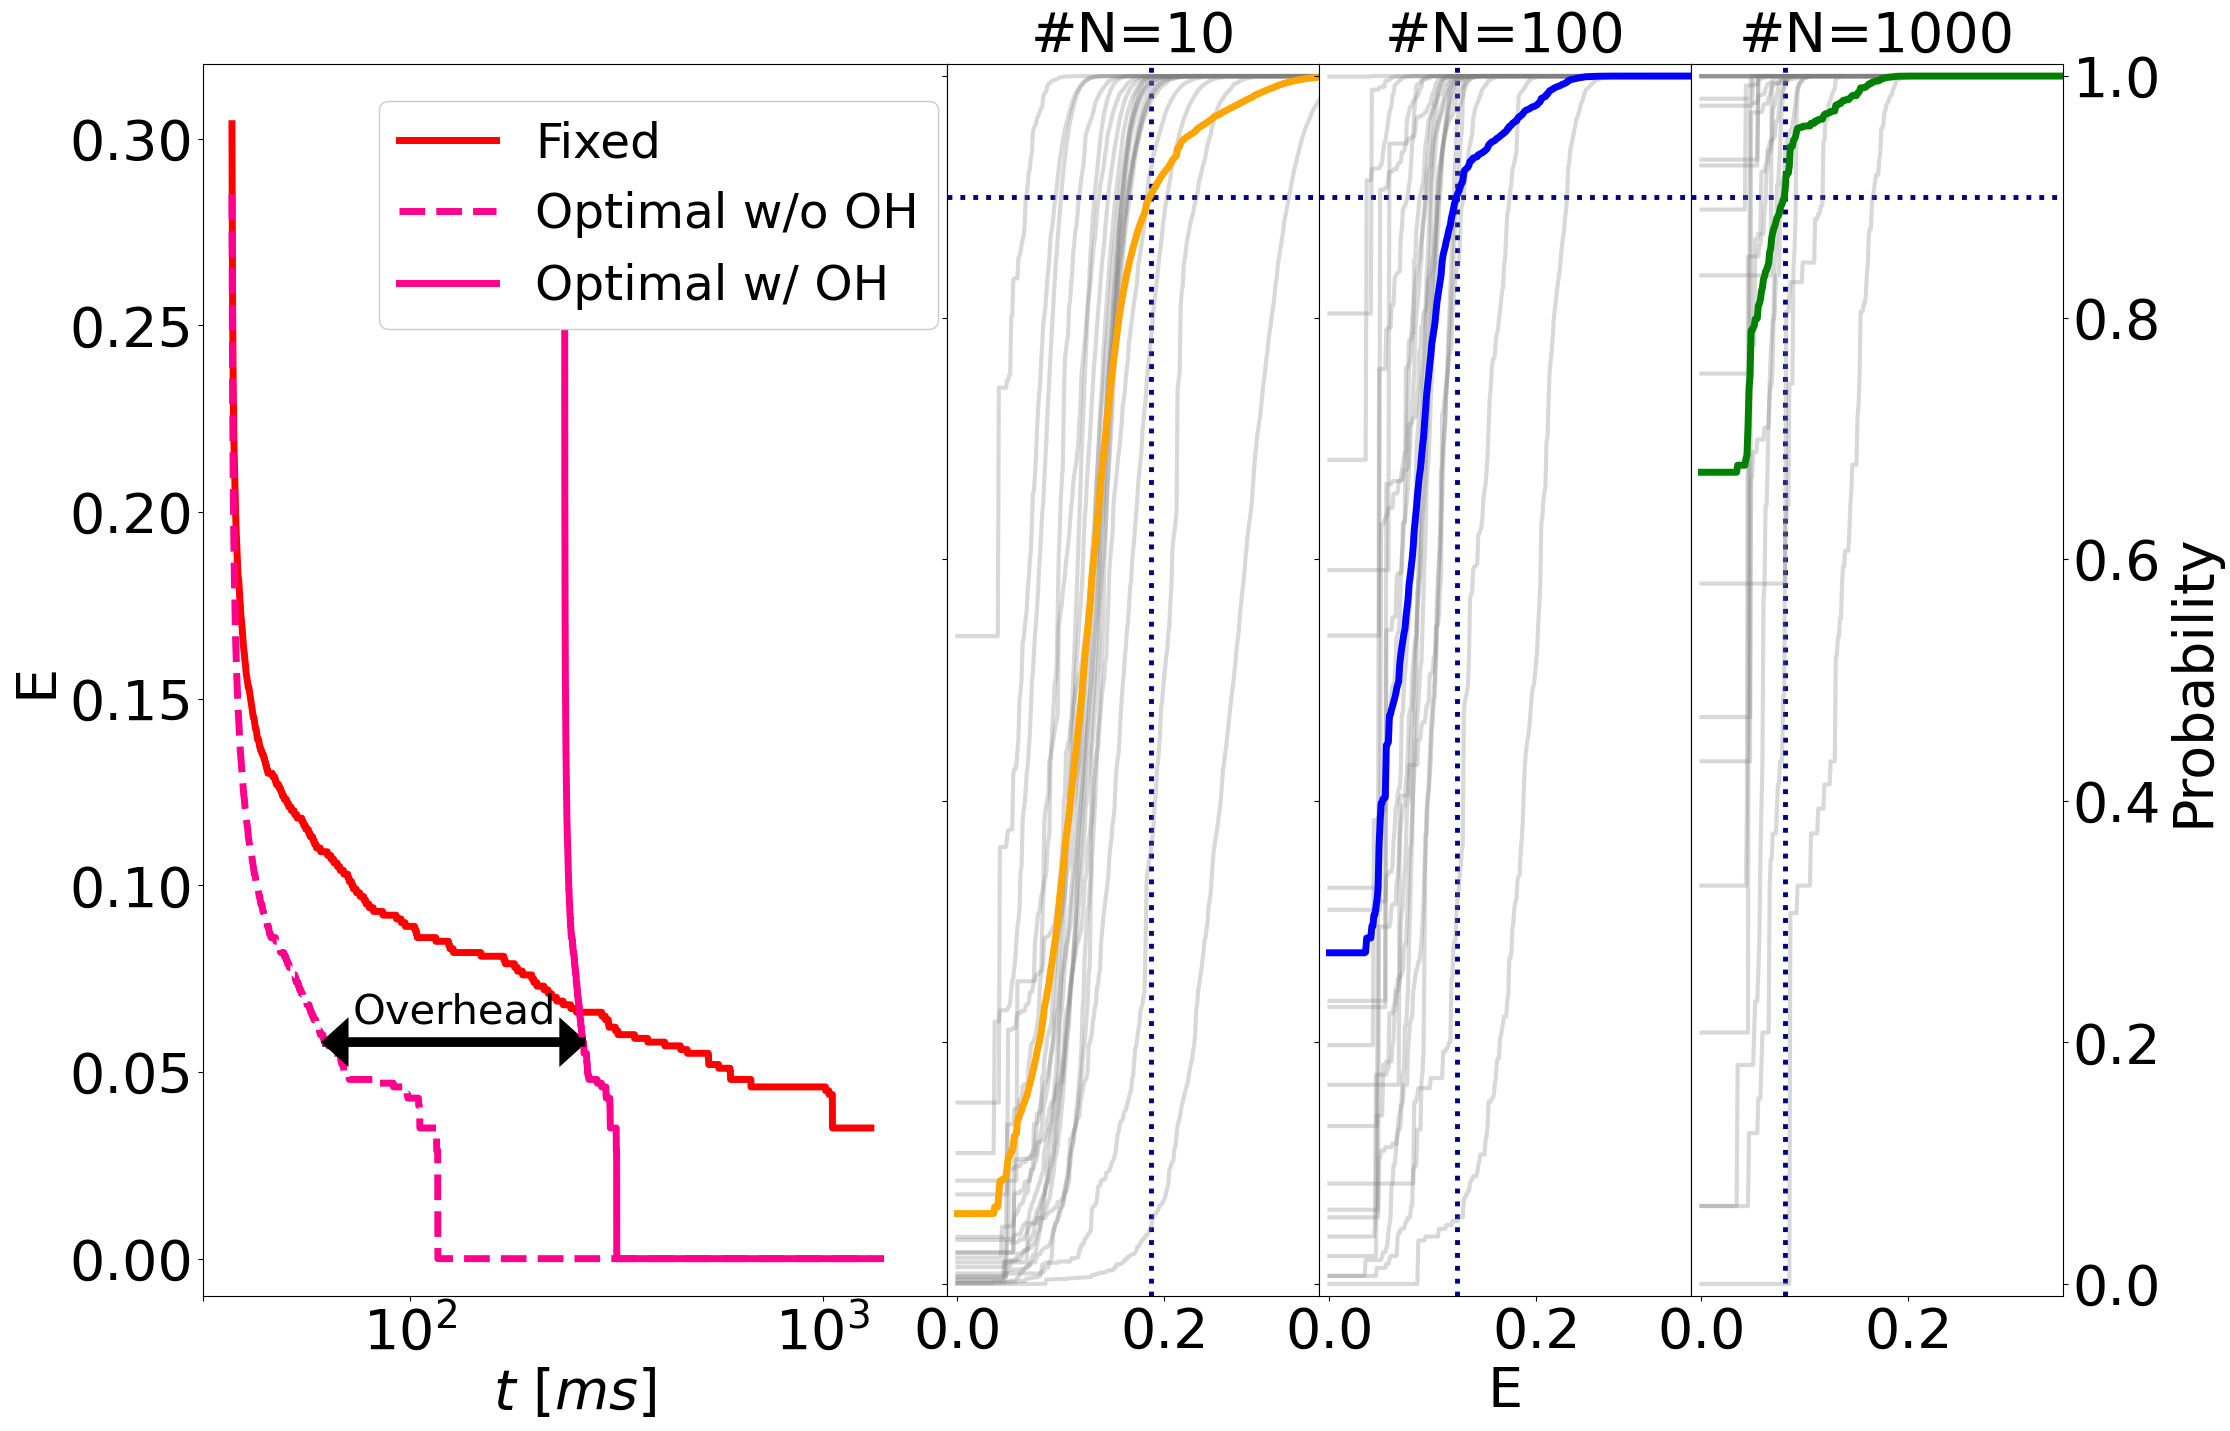

In [8]:
plot_hardness_full(10000, "log")